In [34]:
import pybammeis
import pybamm
import os
import re
import numpy as np
from gamry_parser import GamryParser, Impedance
import pandas as pd
import time as timer
import matplotlib.pyplot as plt
from scipy.fft import fft
import random
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from scipy.interpolate import interp1d
import pyswarms as ps 
from pyswarms.single import GlobalBestPSO

Uploading experimental data

In [35]:
# ved ca. 45% SoC 
# ved 25 deg C

def get_exp_data(i, d): 
    z_list = []
    file = "/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_01_EIS-SoC_01-05/MJ1_01_EIS-SoC_0"+str(i)+"/"+d+"EISGALV3V587.DTA"
    ca = Impedance(file)
    ca.load(filename=file)

    # extract EIS curve
    res = ca.get_curve_data().iloc[::-1]
    df_real = res['Zreal']
    df_imag= res['Zimag']
    df_freq = res['Freq']
    #df_name = res['Vdc']

    # Removing the points beneath the y-axis 
    real = df_real[df_imag <= 0]
    imag = df_imag[df_imag <= 0]
    freq = df_freq[df_imag <= 0]
    
    #name = sum(df_name)/len(df_name)
    # Adding the impendances to the list 
    z_list.append(real)
    z_list.append(imag)
    return[z_list, freq, len(freq)] #, df_name]


In [36]:
def get_vdc(i, d): 
    length = get_exp_data(i, d)[2]
    file = "/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_01_EIS-SoC_01-05/MJ1_01_EIS-SoC_0"+str(i)+"/"+d+"EISGALV3V587.DTA"
    df = pd.read_csv(file, delimiter='\t', skiprows=[i for i in range(0, 60)], encoding='ISO-8859-1')

    df_vdc = df['Vdc'][::-1]
    vdc = df_vdc[:length+1]
    v_list = np.array(vdc)

    sum = 0 
    for i in v_list: 
        sum += float(i) 
    v_avg = sum/len(v_list)

    return v_avg #, df_name]

get_vdc(1, "")

3.572173346938775

Parametre

In [37]:
parametre = {
    "R1": 0.026455095283510706,  # motstand
    "R2": 5.534820787666664e-07, # motstand 
    "C1": 0.0055426231465975665,  # kapasitans
    "C2" : 0.6755099612832921, # kapasitans
    "Rs": 0.6624587164477784, # partikkelstørrelse
    "Ds": 0.0010503007445281985,     # diffusjonskoeffisient 
    "a": 0.5722885441839765,  # overflateareal, porer 
    "L": 0.005384825939881047,  # tykkelse, elektrode 
    "K" : 2.339974970415867,  # ledningsevne elektrolytt 
    "sigma": 0.8629910852751331, # ledningsevne, fast elektrodematerial
    "ebsilon": 0.0011934570596558787,     # porositet 
    }

F = 96485 #C/mol 

Functions to convert list to dictionary or vice versa 

In [38]:
# Function to convert dictionary to list
def dict_to_list(c_elem):
    return list(c_elem.values())

# Function to convert list back to dictionary
def list_to_dict(c_elem, optimized_values):
    keys = list(c_elem.keys())
    return dict(zip(keys, optimized_values))


Endring i potensial med SoC

In [51]:
p_p = np.array([ 0.74041974, 4.39107343, 0.03434767, 18.16841489, 0.53463176, 17.68283504, 14.59709162, 0.28835348, 17.58474971, 14.69911523, 0.28845641])
p_n = np.array([ 1.20912055e+00, 5.62297420e+01, -1.11020020e-01, -2.53458213e-01, 4.92581391e+01, 1.22046522e-02, 4.73538620e-02, 1.79631246e+01, 1.75283209e-01, 1.88038929e-02, 3.03255334e+01, 4.66328034e-01])

def calc_U_x(frequencies, p): 
    x = np.linspace(0,100,len(frequencies)) # the SoC gos from 0 to 100% 
    p_x = (-p[0] * x + p[1] - p[2] * np.tanh(p[3] * (x - p[4])) - p[5] * np.tanh(p[6] * (x - p[7]))+ p[8] * np.tanh(p[9] * (x - p[10])))
    return p_x

def dU_dx(frequencies, pn, pp): 
    pn = calc_U_x(frequencies, pn)
    pp = calc_U_x(frequencies, pp)

    U = pn - pp 
    return U*0.0001

#dU_dx(freq, p_n, p_p)
    





Calculate impedance

In [52]:
# Function to calculate Z 
def calc_Z(comp, frequencies):
    # Update param dictionary from the flat parameter list (comp), where comp is updated values
    param = list_to_dict(parametre, comp) 
    ang_freq = 2 * np.pi * frequencies

    R_part = dU_dx(ang_freq, p_n, p_p)*(param['Rs']/(F*param['Ds']))
    omega_s = (ang_freq*param['Rs']**2)/param['Ds']
    Y_s = (np.sqrt(1j*omega_s) - np.tanh(np.sqrt(1j*omega_s)))/np.tanh(np.sqrt(1j*omega_s))

    # For one specific particle: Y = 1/Z
    Y = 1/((param['R1'] + R_part/Y_s)/(1 + 1j*ang_freq*param['C1']*(param['R1'] + R_part/Y_s)) + param['R2']/(1+1j*ang_freq*param['R2']*param['C2']))

    # The total impedance: 
    v = param['L']/(((param['K']*param['sigma'])/(param['K'] + param['sigma']))**0.5*(np.abs(param['a']*Y))**(-0.5))
    Z = (param['L']/(param['K']+param['sigma']))*(1 + (2 + (param['sigma']/param['K'] + param['K']/param['sigma'])*np.cosh(v))/(v*np.sinh(v)))

    return Z 

# Optimizing the difference function for a given data set
def optimize_diff(i):
    # Load the experimental data 
    exp_real = np.array(get_exp_data(i, "")[0][0])
    exp_imag = np.array(get_exp_data(i, "")[0][1])
    frequencies = np.array(get_exp_data(i, "")[1])

    # Difference function for the optimization
    def diff_func(comp, exp_real, exp_imag):
        Z = calc_Z(comp, frequencies)
        diff_real = Z.real - exp_real
        diff_imag = Z.imag - exp_imag
        sum_square_diff = np.sum(diff_real ** 2 + diff_imag ** 2)
        return sum_square_diff

    # Convert initial dictionary to list for optimization
    initial_elems = dict_to_list(parametre)

    # Optimization options
    options = {
        'maxiter': 10000,    # Maximum number of iterations
        'ftol': 1e-10,       # Function value tolerance
        #'disp': True
    }

    # Minimize the difference function (optimize parameters)
    opt = minimize(diff_func, initial_elems, args=(exp_real, exp_imag), method='TNC', options=options)
    opt_elems = list_to_dict(parametre, opt.x)
    final_diff = diff_func(opt.x, exp_real, exp_imag)
    
    #print("Final sum of squared difference for dataset", i, ":", final_diff)

    return opt_elems, final_diff, frequencies, opt.x 

# Example usage: optimize for a specific dataset (choose i from 1 to 5)
i = 1 # Change i to the desired dataset index
dic_elems, final_diff, frequencies, list_elems = optimize_diff(i)
print(final_diff)



/var/folders/18/pf3m4tds5qs9rpymkqv73yxc0000gn/T/ipykernel_6052/1778571784.py:46: OptimizeWarning: Unknown solver options: maxiter
  opt = minimize(diff_func, initial_elems, args=(exp_real, exp_imag), method='TNC', options=options)


0.0005326401897888739


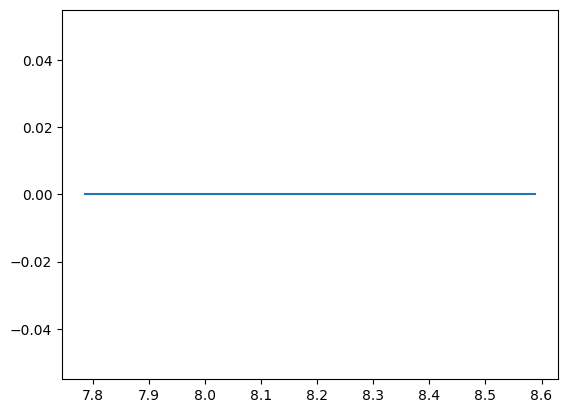

In [58]:
Z_init = calc_Z(dict_to_list(parametre), frequencies)

plt.plot(Z_init.real, -Z_init.imag)
plt.show()

Observe how the parameters are changing with degradation

In [53]:
def finding_params(): 
    dic_list = []
    for l in range(1,6):
        dic_elems, final_diff, frequencies, list_elems = optimize_diff(l)
        dic_list.append(dic_elems)
    
    combined_dict = {}
    
    for d in dic_list:
        for key, value in d.items():
            # If key is not in combined_dict, initialize with empty list
            if key not in combined_dict:
                combined_dict[key] = []
            # Append the value to the list for this key
            combined_dict[key].append(value)

    return combined_dict

In [54]:
combined_dict = finding_params()

def plot_change_param(key_list): 
    x = [1, 2, 3, 4, 5]
    fig, ax = plt.subplots(figsize=(6, 6)) 
    for key in key_list: 
        ax.scatter(x, combined_dict[key], label = key)

    plt.legend()
    plt.xlabel("Data Set Number")
    plt.ylabel("Parameter Value")
    plt.title("Change in Parameters") 
    plt.show()

#plot_change_param(['R1', 'R2'])
#plot_change_param(['Rs', 'Ds'])
#plot_change_param(['C1', 'C2'])
#plot_change_param(['a', 'L'])
#plot_change_param(['K', 'sigma'])
#plot_change_param(['ebsilon'])


/var/folders/18/pf3m4tds5qs9rpymkqv73yxc0000gn/T/ipykernel_6052/1778571784.py:46: OptimizeWarning: Unknown solver options: maxiter
  opt = minimize(diff_func, initial_elems, args=(exp_real, exp_imag), method='TNC', options=options)
/var/folders/18/pf3m4tds5qs9rpymkqv73yxc0000gn/T/ipykernel_6052/1778571784.py:46: OptimizeWarning: Unknown solver options: maxiter
  opt = minimize(diff_func, initial_elems, args=(exp_real, exp_imag), method='TNC', options=options)
/var/folders/18/pf3m4tds5qs9rpymkqv73yxc0000gn/T/ipykernel_6052/1778571784.py:46: OptimizeWarning: Unknown solver options: maxiter
  opt = minimize(diff_func, initial_elems, args=(exp_real, exp_imag), method='TNC', options=options)
/var/folders/18/pf3m4tds5qs9rpymkqv73yxc0000gn/T/ipykernel_6052/1778571784.py:46: OptimizeWarning: Unknown solver options: maxiter
  opt = minimize(diff_func, initial_elems, args=(exp_real, exp_imag), method='TNC', options=options)
/var/folders/18/pf3m4tds5qs9rpymkqv73yxc0000gn/T/ipykernel_6052/17785717

Comparison plot

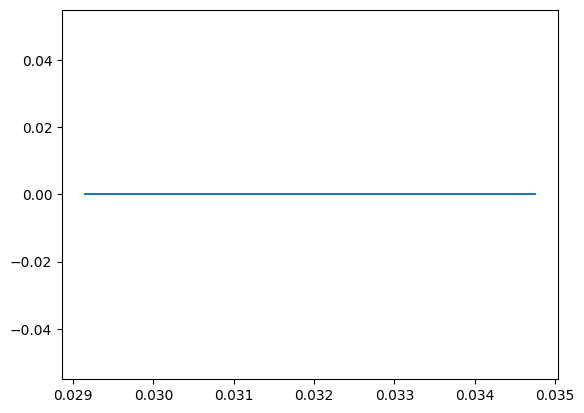

In [55]:
Z = calc_Z(list_elems, frequencies)

plt.plot(Z.real, -Z.imag)
plt.show()

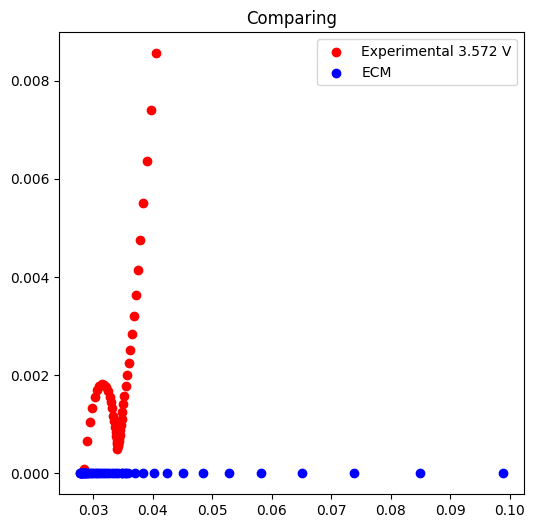

In [47]:

fig, ax = plt.subplots(figsize=(6, 6)) 
ax.scatter(np.array(get_exp_data(i, "")[0][0]), -np.array(get_exp_data(i, "")[0][1]), color = 'red', label=f"Experimental "+str(np.round(get_vdc(i, ""),3))+" V") 
ax.scatter(Z.real, -Z.imag, label = f'ECM', color = 'blue')

#ax.set_xlim(0.016, 0.045) 
#ax.set_ylim(0, 0.012)

plt.legend()
plt.title("Comparing") 
plt.show() 

fig, ax = plt.subplots(figsize=(10, 10)) 
ax.scatter(np.array(get_exp_data(i, "")[0][0]), -np.array(get_exp_data(i, "")[0][1]), color = 'red', label=f"Experimental "+str(np.round(get_vdc(i, ""),3))+" V") 
ax.scatter(Z_randles.real, -Z_randles.imag, label = f'ECM', color = 'blue')

#ax.set_xlim(0.016, 0.045) 
#ax.set_ylim(0, 0.012)

plt.legend()
plt.title("Comparing") 
plt.show() 

In [44]:
def U_n(self, c, c_max):
    sto = c/c_max
    return self.U_n_sto(sto)


def U_p(self, c, c_max):
    sto = c/c_max
    return self.U_p_sto(sto)


def U_n_sto(self, s):
    x = s
    p = np.array([ 1.20912055e+00, 5.62297420e+01, -1.11020020e-01, -2.53458213e-01, 4.92581391e+01, 1.22046522e-02, 4.73538620e-02, 1.79631246e+01, 1.75283209e-01, 1.88038929e-02, 3.03255334e+01, 4.66328034e-01])
    return (p[0] * np.exp(-p[1] * x)+ p[2]- p[3] * np.tanh(p[4] * (x - p[5])) - p[6] * np.tanh(p[7] * (x - p[8])) - p[9] * np.tanh(p[10] * (x - p[11])))


def U_p_sto(self, s):
    x = s
    p = np.array([ 0.74041974, 4.39107343, 0.03434767, 18.16841489, 0.53463176, 17.68283504, 14.59709162, 0.28835348, 17.58474971, 14.69911523, 0.28845641])
    return (-p[0] * x + p[1] - p[2] * np.tanh(p[3] * (x - p[4])) - p[5] * np.tanh(p[6] * (x - p[7]))+ p[8] * np.tanh(p[9] * (x - p[10])))